In this notebook we will take the mushroom images we explored in the previous notebook and try to categorize them properly. 

In [1]:
# First we'll load some relevant libraries

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import seaborn as sns
import time
%matplotlib inline
plt.style.use('seaborn-whitegrid')

os.getcwd()

'/notebooks'

In [2]:
print(os.listdir("../storage/Mushrooms"))

['Hygrocybe', 'Boletus', 'Cortinarius', '.ipynb_checkpoints', 'Russula', 'Suillus', 'Entoloma', 'Amanita']


In [3]:
%reload_ext autoreload
%autoreload 2

This notebook originates from a Tensorflow notebook on Paperspace Gradient. We'll load the relevant libraries for the model, including ResNet50, a Residual Network model commonly used in computer vision tasks where transfer learning can help improve both the speed and accuracy of a model. 

In [4]:
import tensorflow as tf
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPool2D

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

ResNet50 comes preloaded with different weights, depending on what it was previously trained on. Here we'll use the "imagenet" weights to preload our model. Note the extremely deep nature of this learning network. 

In [5]:
# Load ResNet50 model:
resnet_model = ResNet50(weights="imagenet")
resnet_model.summary()

W1214 01:14:07.665449 140552573691712 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [6]:
#Based on trial and error, we arrive at 300x300 and a good image size to resize each image to. 

img_rows=300
img_cols=300

In [7]:
# We'll use these libraries to Imgae processing.

from PIL import Image
import glob

In [8]:
cats = os.listdir("../storage/Mushrooms")

In [9]:
cats

['Hygrocybe',
 'Boletus',
 'Cortinarius',
 '.ipynb_checkpoints',
 'Russula',
 'Suillus',
 'Entoloma',
 'Amanita']

In [10]:
del cats[3]

The list "cats" represents the seven mushroom we will classify here. Each mushroom is a subfolder of images from that specific genus. 

In [11]:
cats

['Hygrocybe',
 'Boletus',
 'Cortinarius',
 'Russula',
 'Suillus',
 'Entoloma',
 'Amanita']

In [12]:
# We'll create another list, this tracks the number of useable files in each subfolder for later use when we label the images.

lengths = []

for k in np.arange(len(cats)):
    bad = 0
    filelist = os.listdir("../storage/Mushrooms/"+cats[k])
    for x in filelist:
        if x[-1] != 'g':   #When a non-jpeg file is found, the counter called "bad" increments.
            bad = bad + 1
    lengths.append(len(filelist)-bad)

In [13]:
# Here's an example of a file list that contains an item that's not a jpg image.
# (If you scroll down you'll see an ipynb file. )

os.listdir("../storage/Mushrooms/"+cats[6])

['446_NSCwevmikZY.jpg',
 '161_n8NbNSHDNfw.jpg',
 '057_kcgTzjdCH98.jpg',
 '472_vxTtgNhg7lc.jpg',
 '748_iWLxylB00lM.jpg',
 '749_Kwa9kDjoczs.jpg',
 '360_93di97sjY40.jpg',
 '519_B6JXPwmtHAc.jpg',
 '581_MFN1aDZ95Hs.jpg',
 '782_fqegXGS2jxM.jpg',
 '303_db7f-9_bQu0.jpg',
 '451_V0quFnk9NFA.jpg',
 '392_dnsTD3pYLG0.jpg',
 '131_dvJEzL2mKmA.jpg',
 '447_YuqrlLRUFco.jpg',
 '480_808xmF4b26Y.jpg',
 '508_DMB-oiAz_yg.jpg',
 '584_fegtvHpgi44.jpg',
 '619_4lsqCR9RAj4.jpg',
 '212_FiQaXKH5K-Y.jpg',
 '759_6SqS62h11EE.jpg',
 '745_-WeedYJs__8.jpg',
 '150_vJrbkDOJ-OE.jpg',
 '378_Vp82kVzJkSM.jpg',
 '331_za5pbjsDXLU.jpg',
 '681_kHekfyrqLHs.jpg',
 '121_0mE3kiyOk4k.jpg',
 '520_7tXL64TQTpg.jpg',
 '010_Ji4N7IDyRKY.jpg',
 '505_mwF2upQEZq8.jpg',
 '017_NOBUxtHiHRg.jpg',
 '335_dsHW8FLvKg0.jpg',
 '165_PU6GbkbSE7c.jpg',
 '361_s-NKGmZ6D3o.jpg',
 '484_HtMBGuOvyE8.jpg',
 '139_2tM1nrJmAeY.jpg',
 '501_T6o-bipt9YE.jpg',
 '682_B3EZBbmcFBE.jpg',
 '073_7cmeDAddxfw.jpg',
 '290_8VTdQ2j5LL0.jpg',
 '213_t3zSqinP9r8.jpg',
 '008_euaqSUZFtM

In [14]:
#from scipy import misc

## Processing the images into an array ##

The most barebones way of reading the images into the model is as an array. Here, "train_data" will be the array that we will pull training, validation and testing sets from.  

While we're creating this list, we'll also do some data augmentation; specifically, for each image we'll make copy images that are flipped and rotated. This will help, to some extent anyway, with overfitting. 

In [15]:
train_data = []


for k in np.arange(len(cats)):

    for filename in glob.glob('../storage/Mushrooms/'+ cats[k] +'/*.jpg'): #assuming jpg
        im=Image.open(filename)

        im1 = im.resize((img_rows,img_cols))  # Use the image size we declared above
        im2 = im1.transpose(Image.FLIP_LEFT_RIGHT) # Create a image copy that's flipped
        im3 = im1.transpose(Image.ROTATE_90)  # Create an image copy that's rotated. 
        im1 = np.asarray( im1, dtype="int32" )
        train_data.append(im1)
        im2 = np.asarray(im2, dtype = 'int32')
        train_data.append(im2)
        im3 = np.asarray(im3, dtype = 'int32')
        train_data.append(im3)


In [16]:
train_data = np.asarray(train_data)

In [17]:
# Here we'll use the lengths list we created earlier to generate our label set.
# We multiply each item in the list by three since we made two copies in train_data above. 
# We shoudl end up with the same number of rows as in train_data. 

train_labels = np.concatenate((np.zeros((lengths[0]*3,), dtype=int),np.ones((lengths[1]*3,), dtype=int), np.repeat(2,lengths[2]*3),np.repeat(3,lengths[3]*3),np.repeat(4,lengths[4]*3), np.repeat(5,lengths[5]*3),np.repeat(6,lengths[6]*3)),axis=0)

print(train_labels, train_labels.shape)

[0 0 0 ... 6 6 6] (5070,)


## Randomizing the images ##  
None of the mushroom folders are random selections of images; Similar-looking mushroom images are sort of grouped together, in fact. To deal with this, we'll use train-test-split techniques to randomize what goes into the various datasets. 

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
# We will hold out 10% of the full data array for testing at the end. 

X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size = 0.1, random_state=49)

In [20]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4563, 300, 300, 3) (507, 300, 300, 3) (4563,) (507,)


In [21]:
# Last step to prep the datasets is to one-hot encode the categories (0 through 6) into seven different columns.


train_labels = tf.keras.utils.to_categorical(y_train)
test_labels = tf.keras.utils.to_categorical(y_test)

In [22]:
print(X_train.shape, train_labels.shape)

(4563, 300, 300, 3) (4563, 7)


## Model Creation ##

In [23]:
categories = len(cats)

model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

model.add(ResNet50(include_top = False, pooling = 'max', weights = 'imagenet'))

model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(categories, activation = 'softmax'))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 9

In [24]:
# Through more trial and error it was found that redusing learning rate helped overall test set accuracy.
# Here we will set the lr to 1E-7:

tf.keras.optimizers.Adam(learning_rate=0.0000001)

In [25]:
#  The model is compiled with categorical crossentropy and accuracy as the guiding metric. 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

EarlyStopping and lr reduction on plateau are two useful techniques to dealing with models that tend to plateau. If the model flattens out too much, it will quit before it reaches the full number of iterations, or epochs. 

In [26]:
# Introduce callbacks to be exercised during training:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_acc', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.1,
                              mode='max', cooldown=2, patience=2, min_lr=0)

## Modeling and Performance ##  

With the model set up above, we'll run for 50 epochs, peeling off 20% of the training set as a validation set to see how we're doing along the way.

In [27]:
# Train new model:
history = model.fit(X_train, train_labels, validation_split=0.2, epochs=50, callbacks=[reduce_lr, early_stop])

Train on 3650 samples, validate on 913 samples
Epoch 1/50
3650/3650 [==============================] - 32s 9ms/sample - loss: 0.7230 - acc: 0.7493 - val_loss: 0.8447 - val_acc: 0.7514
Epoch 2/50
3650/3650 [==============================] - 26s 7ms/sample - loss: 0.1557 - acc: 0.9575 - val_loss: 0.5601 - val_acc: 0.8182
Epoch 3/50
3650/3650 [==============================] - 27s 7ms/sample - loss: 0.0860 - acc: 0.9795 - val_loss: 0.5075 - val_acc: 0.8302
Epoch 4/50
3650/3650 [==============================] - 27s 7ms/sample - loss: 0.0539 - acc: 0.9910 - val_loss: 0.5485 - val_acc: 0.8018
Epoch 5/50
3650/3650 [==============================] - 27s 7ms/sample - loss: 0.0476 - acc: 0.9888 - val_loss: 0.4786 - val_acc: 0.8456
Epoch 6/50
3650/3650 [==============================] - 27s 7ms/sample - loss: 0.0352 - acc: 0.9921 - val_loss: 0.6127 - val_acc: 0.7963
Epoch 7/50
3650/3650 [==============================] - 27s 7ms/sample - loss: 0.0362 - acc: 0.9915 - val_loss: 0.5268 - val_acc: 0

In [28]:
# Loss during training:
history_frame = pd.DataFrame(history.history)

Text(0.5, 0, 'Epochs')

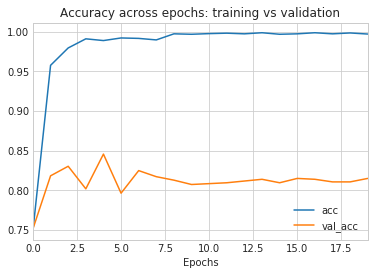

In [29]:
history_frame.loc[:,['acc','val_acc']].plot()
plt.title('Accuracy across epochs: training vs validation')
plt.xlabel('Epochs')

Text(0.5, 0, 'Epochs')

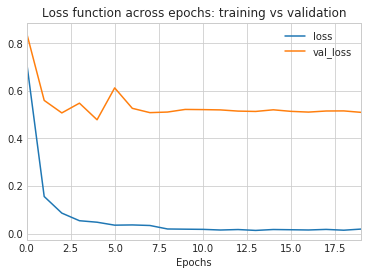

In [30]:
history_frame.loc[:,['loss','val_loss']].plot()
plt.title('Loss function across epochs: training vs validation')
plt.xlabel('Epochs')

In [31]:
loss, accuracy = model.evaluate(X_test, test_labels, verbose=2)
print(f'Model performance on test images:\nAccuracy = {accuracy}\nLoss = {loss}')

507/507 - 3s - loss: 0.4552 - acc: 0.8540
Model performance on test images:
Accuracy = 0.8540433645248413
Loss = 0.45519588123529386


## Results ##  

So, the model managed to achieve nearly 87% accuracy on the unseen, randomized test set. This definitely puts this model out of my league - there's no way I could get even close to that accuracy on the test set. For example, in my preliminary look at ten of the test set images, I managed to correctly guess just THREE of them. That's 30%. 

In [32]:
from sklearn.metrics import confusion_matrix

In [33]:
y_pred = model.predict_classes(X_test)

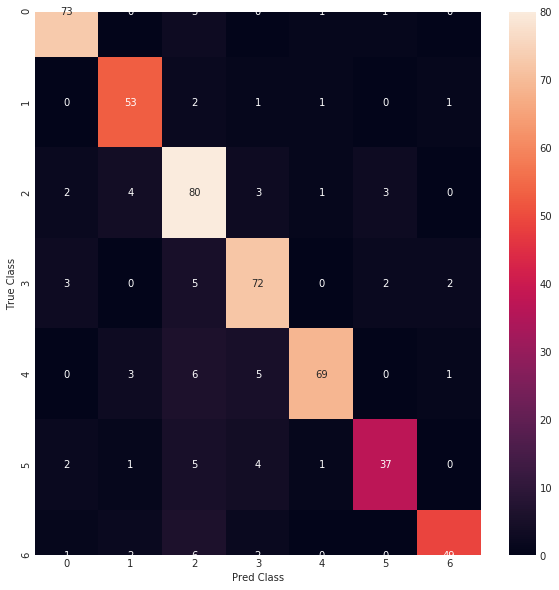

In [34]:
df = pd.DataFrame(confusion_matrix(y_test, y_pred))

plt.figure(figsize=[10,10])
sns.heatmap(df, annot=True, fmt='d')
plt.ylabel('True Class'), plt.xlabel('Pred Class')
plt.show()

## Exploring improperly categorized images ##  

What do some of the incorrectly categorized images look like? 

In [35]:
incorrects = np.nonzero(model.predict_classes(X_test).reshape((-1,)) != y_test)

(-0.5, 299.5, 299.5, -0.5)

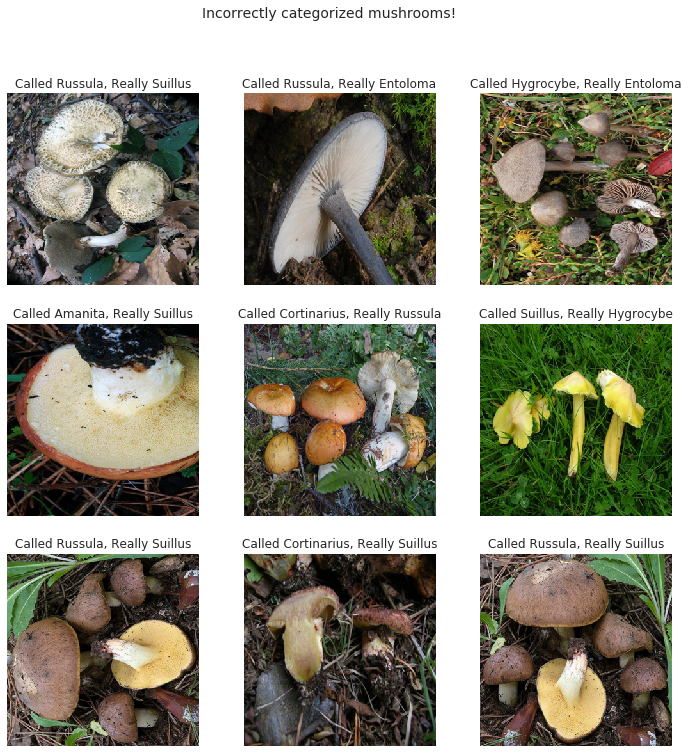

In [50]:
f, axarr = plt.subplots(3,3, figsize = (12, 12))
f.suptitle("Incorrectly categorized mushrooms!", fontsize=14)
axarr[0,0].imshow(X_test[incorrects[0][0]])
string = 'Called ' + cats[y_pred[incorrects[0][0]]]+ ", Really "+ cats[y_test[incorrects[0][0]]]
axarr[0,0].set_title(string)
axarr[0,0].axis('off')
axarr[0,1].imshow(X_test[incorrects[0][1]])
string = 'Called ' + cats[y_pred[incorrects[0][1]]]+ ", Really "+ cats[y_test[incorrects[0][1]]]
axarr[0,1].set_title(string)
axarr[0,1].axis('off')
axarr[0,2].imshow(X_test[incorrects[0][2]])
string = 'Called ' + cats[y_pred[incorrects[0][2]]]+ ", Really "+ cats[y_test[incorrects[0][2]]]
axarr[0,2].set_title(string)
axarr[0,2].axis('off')
axarr[1,0].imshow(X_test[incorrects[0][3]])
string = 'Called ' + cats[y_pred[incorrects[0][3]]]+ ", Really "+ cats[y_test[incorrects[0][3]]]
axarr[1,0].set_title(string)
axarr[1,0].axis('off')
axarr[1,1].imshow(X_test[incorrects[0][4]])
string = 'Called ' + cats[y_pred[incorrects[0][4]]]+ ", Really "+ cats[y_test[incorrects[0][4]]]
axarr[1,1].set_title(string)
axarr[1,1].axis('off')
axarr[1,2].imshow(X_test[incorrects[0][5]])
string = 'Called ' + cats[y_pred[incorrects[0][5]]]+ ", Really "+ cats[y_test[incorrects[0][5]]]
axarr[1,2].set_title(string)
axarr[1,2].axis('off')
axarr[2,0].imshow(X_test[incorrects[0][6]])
string = 'Called ' + cats[y_pred[incorrects[0][6]]]+ ", Really "+ cats[y_test[incorrects[0][6]]]
axarr[2,0].set_title(string)
axarr[2,0].axis('off')
axarr[2,1].imshow(X_test[incorrects[0][7]])
string = 'Called ' + cats[y_pred[incorrects[0][7]]]+ ", Really "+ cats[y_test[incorrects[0][7]]]
axarr[2,1].set_title(string)
axarr[2,1].axis('off')
axarr[2,2].imshow(X_test[incorrects[0][8]])
string = 'Called ' + cats[y_pred[incorrects[0][8]]]+ ", Really "+ cats[y_test[incorrects[0][8]]]
axarr[2,2].set_title(string)
axarr[2,2].axis('off')

Based on these few examples, it seems like the model is having particular trouble with Suillus mushrooms. In this particular case I think a trained human expert would have noticed the lack of gills as being a sign as being most likely either a Boletus or a Suillus. But overall, an accuracy of > 85% on this rather challenging image set is rather satisfactory. 